In [1]:
import pandas as pd
import itertools
import spacy
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud


## Load Data

For now, let work with posts, would be nice if you could replicate this notebook with comments. 

In [2]:
data=pd.read_csv('the-reddit-climate-change-dataset-posts.csv')

For now let us only consider the following variables

* subreddit.name
* created_utc
* permalink
* domain
* url
* selftext
* title
* score


**Task**: 

Add in this notebook, based on the description of the dataset provided in kaggle, the meaning of each of the variables above.
For instance, `score` is the number of votes given to the post and answer: Why do you think we had no use for the rest of them?

In [3]:
slected_variables=["subreddit.name", "created_utc", "permalink", "domain", "url", "selftext", "title", "score"]

In [4]:
data=data[slected_variables].copy()

**Task**: 


Could you add a conclusion based on `data.info()` below ?

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620908 entries, 0 to 620907
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   subreddit.name  620908 non-null  object
 1   created_utc     620908 non-null  int64 
 2   permalink       620908 non-null  object
 3   domain          620908 non-null  object
 4   url             453760 non-null  object
 5   selftext        167148 non-null  object
 6   title           620908 non-null  object
 7   score           620908 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 37.9+ MB


Here is an example of an entry in our dataset:

In [6]:
data.iloc[0]

subreddit.name                                  democraticsocialism
created_utc                                              1661990237
permalink         https://old.reddit.com/r/DemocraticSocialism/c...
domain                                                  twitter.com
url               https://twitter.com/SusanofTexas/status/156480...
selftext                                                        NaN
title             “Cities without water” is our future. The lead...
score                                                            15
Name: 0, dtype: object

Example of a post

In [7]:
data["title"].iloc[0]

'“Cities without water” is our future. The leaders are watching us to see how we react. If we accept this situation as inevitable because the victims are poor and Black, we are teaching our leaders they can abandon us in climate change droughts and we will let them.'

Since we are interested in the users behaviour over a certain period of time, sometimes there is a need to create eitherc more informative variables or to transform the ones we already have. This is sometimes refer in ML as *feature engineering*.

For example, it isn't strightforward to identy the date with `created_utc` as it is, we must consider a transformation to have a more interpretable representation, in our case is `pd.to_datetime(data['created_utc'], unit='s')` (*Look it up*)

In [8]:
data['created_utc'] = pd.to_datetime(data['created_utc'], unit='s')
data['year'] = data['created_utc'].dt.year

In [9]:
data['year'].unique()

array([2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012,
       2011, 2010], dtype=int32)

Notice we have posts from 2010 to 2022. For fun, let us only consider before and after 2012, due to a rumor the world was to be ended in such year. 

In [10]:
data_bf=data[data['year']<=2012].copy()
data_af=data[data['year']>2012].copy()

****

# Exploratory Data Analysis

The function below returns the frequency of each category.  

In [29]:
def count_categories(categories):
    category_counts = {}
    for category in categories:
        if category in category_counts:
            category_counts[category] += 1
        else:
            category_counts[category] = 1

    return list(category_counts.items())

In [32]:
categories_count = count_categories(data['subreddit.name']) 
print(categories_count)

[('showerthoughts', 32), ('blogs', 1), ('politics', 14), ('findareddit', 1), ('unpopularopinion', 24), ('shitamericanssay', 1), ('talkativepeople', 194), ('tytnetwork', 2), ('askreddit', 58), ('theolympianempire', 1), ('prayerrequests', 1), ('askscience', 37), ('climateskeptics', 7), ('debaterightists', 16), ('climatechange', 34), ('tunisia', 1), ('facepalm', 1), ('toiletpaperusa', 2), ('climate', 10), ('u_pennbookcenters', 1), ('globalwarming', 3), ('environment', 32), ('skeptic', 1), ('christianity', 1), ('conspiracy', 14), ('anarcho_capitalism', 1), ('nottheonion', 7), ('cycling', 1), ('todayilearned', 3), ('collapse', 9), ('askwomenover30', 1), ('mechanicadvice', 1), ('climategoblin', 1), ('stockmarketnews', 2), ('europe', 3), ('boston', 1), ('autotldr', 41), ('worldnews', 14), ('animalvideo', 1), ('anticonsumption', 2), ('worldpolitics', 1), ('explainlikeimfive', 14), ('climate_science', 4), ('removalbot', 14), ('publicfreakout', 1), ('funny', 5), ('conservativelounge', 1), ('vega

Lets now see if the most frequent categories changed after 2012.

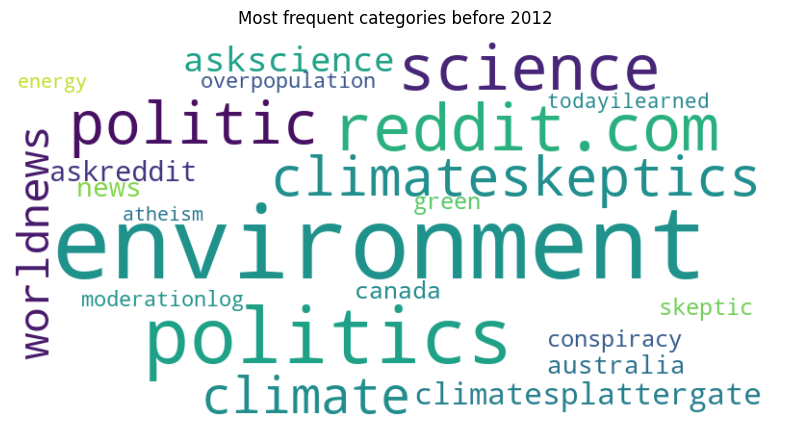

In [13]:
categories_count = count_categories(data_bf['subreddit.name']) 
filtered_categories = list(itertools.filterfalse(lambda x: x[1] <= 100, categories_count))
word_freq_dict = dict(filtered_categories)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)
plt.figure(figsize=(10, 5))
plt.title("Most frequent categories before 2012")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

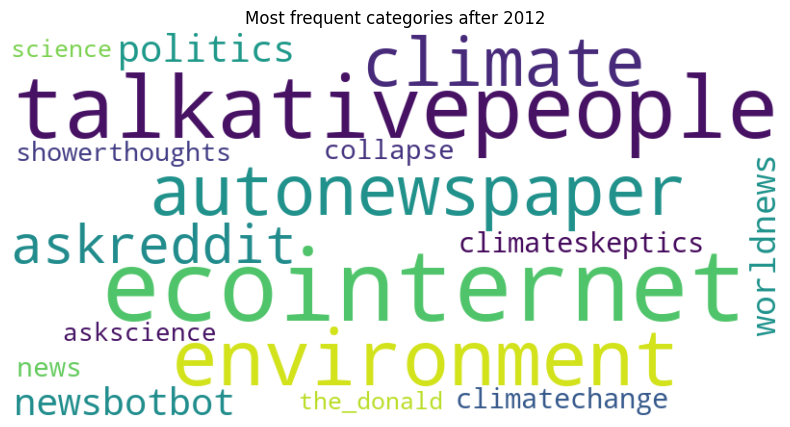

In [14]:
categories_count = count_categories(data_af['subreddit.name']) 
filtered_categories = list(itertools.filterfalse(lambda x: x[1] <= 5000, categories_count))
word_freq_dict = dict(filtered_categories)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)
plt.figure(figsize=(10, 5))
plt.title("Most frequent categories after 2012")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.show()

**Task**: 

Add a conclusion below with the differences (if exists) between before and after 2012 most frequent categories. Is the code the same? what changed?

## Finding Entities  

In [15]:
# For now, lets only use complete data. 
data = data.dropna(subset=['selftext'])

In [16]:
data=data.sample(n=1000).reset_index(drop=True)

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/cipri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# Load Spacy model and stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))  # Set for faster lookup

/Users/cipri/Library/Caches/pypoetry/virtualenvs/climatechangenlp-LA-ptWe9-py3.12/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [19]:
# Remove stopwords from the text
data['selftext'] = data['selftext'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

In [20]:
# Function to extract locations (GPE entities) from text
def extract_locations(text):
    return [ent.text for ent in nlp(text).ents if ent.label_ == 'GPE']

In [21]:
# Extract locations from the 'body' column
locations = [loc for sublist in data['selftext'].apply(extract_locations) for loc in sublist]

In [22]:
# Get top 50 most common locations
most_common_50 = Counter(locations).most_common(50)

In [23]:
# Prepare data for plotting
all_locs = [loc for loc, _ in most_common_50]
num_loc_mentions = [count * 50 for _, count in most_common_50]
avg_loc_sents = [data[data['selftext'].str.contains(loc, regex=False)]['score'].mean() for loc in all_locs]

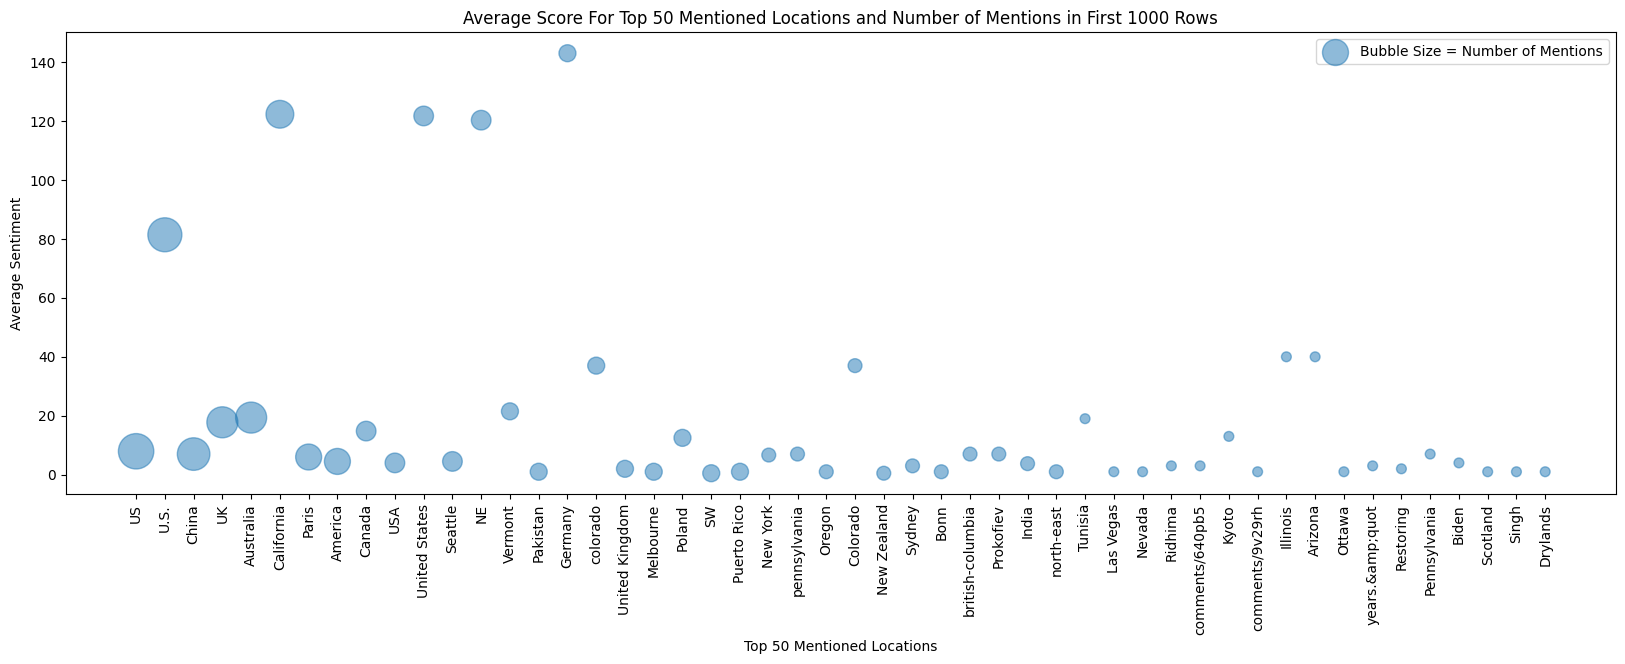

In [24]:
# Plotting the data
plt.figure(figsize=(20, 6))
plt.scatter(all_locs, avg_loc_sents, s=num_loc_mentions, alpha=0.5)
# Add titles and labels
plt.title("Average Score For Top 50 Mentioned Locations and Number of Mentions in First 1000 Rows")
plt.xlabel("Top 50 Mentioned Locations")
plt.xticks(rotation=90)
plt.ylabel("Average Sentiment")
plt.legend(["Bubble Size = Number of Mentions"])
plt.show()


**Task**: 

Do you think this plot is okay as it is? Should we filtered it more? how? Try to refine the above plot using your own logic (have fun with it).

In [25]:
#START NAMES
def extract_names(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ == 'PERSON']

In [26]:
persons = [person for sublist in data['selftext'].apply(extract_names) for person in sublist]
most_common_50 = Counter(persons).most_common(50)

# Prepare data for plotting
all_persons = [person for person, _ in most_common_50]
num_person_mentions = [count * 50 for _, count in most_common_50]
avg_loc_scores = [data[data['selftext'].str.contains(person, regex=False)]['score'].mean() for person in all_persons]

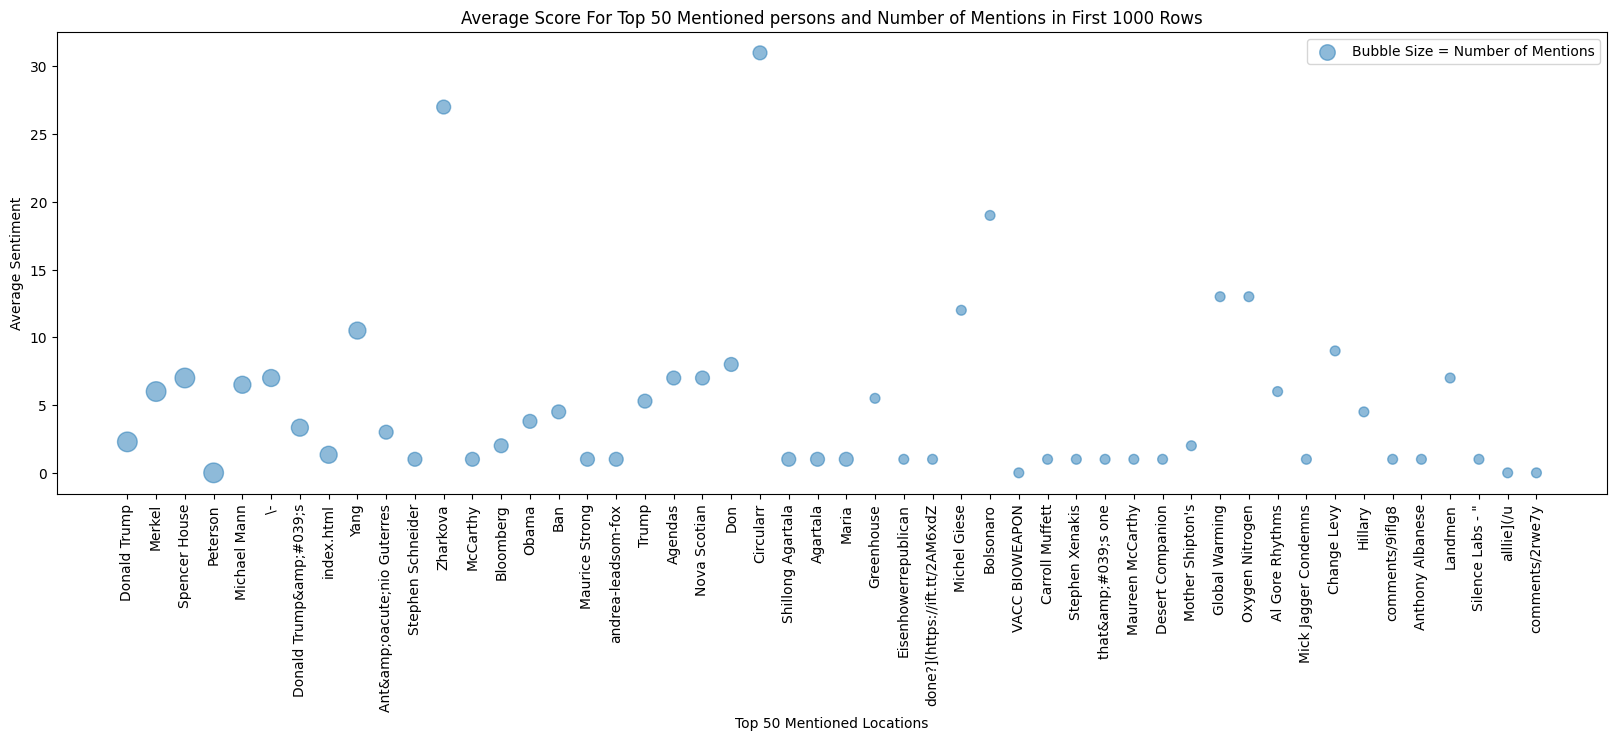

In [27]:
# Plotting the data
plt.figure(figsize=(20, 6))
plt.scatter(all_persons, avg_loc_scores, s=num_person_mentions, alpha=0.5)
# Add titles and labels
plt.title("Average Score For Top 50 Mentioned persons and Number of Mentions in First 1000 Rows")
plt.xlabel("Top 50 Mentioned Locations")
plt.xticks(rotation=90)
plt.ylabel("Average Sentiment")
plt.legend(["Bubble Size = Number of Mentions"])
plt.show()

**Task**: 

Add a conclusion

# Extra: 

This is some preview of our future work, but keep them in mind and try to find some other interesting questions or suggest ideas to answer the ones below.

Strongly suggest to use chatGPT.

1. What is the number of posts per year?
2. Average score (number of votes) per year per category ?
3. We want to measure popularity and influence of the found persons.  How can we measure popularity and/or Influence?
5. How people are affected and cope with climate change? For example, who engages in these kind of conversations, can we say something about their age or context of the authors of these posts? (This also called author profiling)
6. How can we identify false information or fake news with this data?